In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
from tqdm.notebook import tqdm_notebook
from copy import deepcopy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from collections import defaultdict
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16
%matplotlib inline

C:\Users\Sali1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

# Task 1 

### Field 3 x 3

In [4]:
env = TicTacToe()

In [5]:
def e_greedy(env, Q, epsilon = 0.01):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    if env.getState()[0] not in Q.keys():
        Q[env.getState()[0]] = np.zeros(len(possible_actions))
        
    if np.random.random() > epsilon:
        return np.argmax(Q[env.getState()[0]]), possible_actions[np.argmax(Q[env.getState()[0]])]
    else:
        ch = np.random.choice(len(possible_actions))
        return ch, possible_actions[ch]

In [6]:
def Q_learning_episode(strategy, env, Q, lr = 0.01, gamma = 1., crosses = 1, *args, **kwargs):
    env.reset()
    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
        
    while True:
        #getting current state
        state = env.getState()[0]

        #action acording to the strategy
        q_action, action = strategy(env, Q, *args, **kwargs)

            # step
        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            #env.printBoard()
            return reward

            #oppponents turn
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            
            #opponent step
        next_state_, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            #env.printBoard()
            return reward
            
        next_state = next_state_[0]
        if next_state in Q.keys():
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
        else:
            possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            Q[next_state] = np.zeros(len(possible_actions))
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
            #env.printBoard()

In [7]:
def run_many_games_Q_learning(strategy, env = TicTacToe(), n_games = 100000, verbose = True, print_every = 1000, crosses = 1, *args, **kwargs):
    mean_game_rewards = []
    avg_every = []
    Q = {}
    for i in tqdm_notebook(range(n_games)):
        R = Q_learning_episode(strategy, env, Q, crosses = crosses, *args, **kwargs)
        avg_every.append(R)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, n_games) + " avg rewards: {}".format(np.mean(avg_every)))
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards

In [8]:
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, verbose = False, crosses = 1)
Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, verbose = False, crosses = -1)

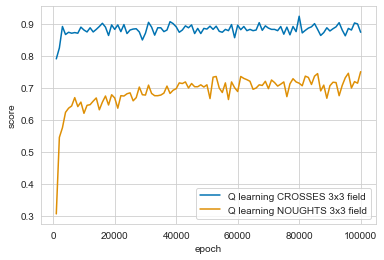

In [9]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'Q learning CROSSES 3x3 field')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'Q learning NOUGHTS 3x3 field')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend();

### Field 4 x 4

In [10]:
env = TicTacToe(4,4,4)
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, env = env, n_games = 100000, verbose = False, crosses = 1)
Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, env = env, n_games = 100000, verbose = False, crosses = -1)

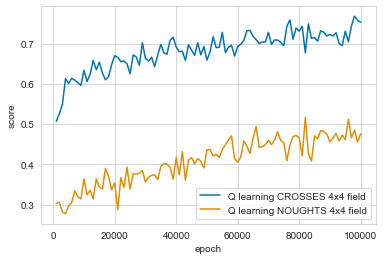

In [11]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'Q learning CROSSES 4x4 field')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'Q learning NOUGHTS 4x4 field')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend();

### Field 5 x 5

In [12]:
env = TicTacToe(5,5,5)
Q_crosses, rewards_q_learning_crosses = run_many_games_Q_learning(e_greedy, env = env, n_games = 100000, verbose = False, crosses = 1)
Q_nills, rewards_q_learning_nills = run_many_games_Q_learning(e_greedy, env = env, n_games = 100000, verbose = False, crosses = -1)

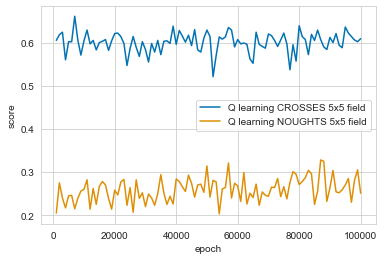

In [14]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label = 'Q learning CROSSES 5x5 field')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label = 'Q learning NOUGHTS 5x5 field')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend();

# Task 2

In [23]:
Capcity = 10000
N_games = 10000
n_chanels = 9
batch_size = 64
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [16]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [17]:
class DQN(nn.Module):
    def __init__(self, field_size):
        super(DQN, self).__init__()
        self.field_size = field_size
        
        self.conv = nn.Conv2d(1, self.field_size * self.field_size, kernel_size = self.field_size)
        
    def forward(self, x):
        x = self.conv(x)
        return x
    
class DQN_noughts(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DQN_noughts, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
    def forward(self, x):
        x = F.relu(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        x = self.l(x)
        return x

In [18]:
def e_greedy_dqn(env, dqn, epsilon = 0.01, device = device):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    fstate = torch.Tensor(env.board)
    actions = dqn(fstate.unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).cpu().detach().numpy()
    #print(possible_actions)
    Q_actions = actions[possible_actions] 
    #print(epsilon)
    if np.random.random() > epsilon:
        return possible_actions[np.argmax(Q_actions)]
    else:
        return np.random.choice(possible_actions)

In [19]:
def dqn_learn(dqn, memory, optimizer, gamma):
    batch = memory.sample(batch_size)
    
    fstate_batch = [el[0] for el in batch]
    
    actions = np.array([el[1] for el in batch])
    
    fnext_state_batch = [el[2][0] for el in batch]
    isTermanal = [el[2][1] for el in batch]
    fnext_actions = [el[2][2] for el in batch]
    
    reward = np.array([el[3] for el in batch])
    
    with torch.no_grad():
        predictions = dqn(torch.Tensor(fnext_state_batch).unsqueeze(1).to(device)).cpu().detach().numpy()
        predicted_target = gamma * np.array(
            [np.max(predictions[i][fnext_actions[i]]) if fnext_actions[i] != [] else 0. for i in range(batch_size)])
        predicted_target += reward
        target = torch.Tensor([reward[i] if isTermanal[i] else predicted_target[i] for i in range(batch_size)])
    
    predictions = dqn(torch.Tensor(fstate_batch).unsqueeze(1).to(device)).cpu().squeeze()

    loss = F.mse_loss(predictions[np.arange(batch_size), actions], target)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

In [20]:
def DQN_train_episode(env, NN, optimizer, memory, gamma = 1., crosses = 1, Capcity = Capcity, device = device, *args, **kwargs):
    env.reset()
    
    # if we are o
    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    loss = 0.
    
    while True:
        #---------------
        # OUR TURN
        #---------------
            
        # getting current state
        fstate = env.board
        fstate_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        
        # action according policy
        action = e_greedy_dqn(env, NN, *args, **kwargs)
        #print('action', action)
        # step and win
        #print(env.step(env.action_from_int(action)))
        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss
            
        #---------------
        # Oppponents TURN
        #---------------
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            
        #oppponents step
        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        
        if done:
            memory.push(fstate, action, (env.board, done, []), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)
            return reward, loss
        else:
            fnext_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            memory.push(fstate, action, (env.board, not done, fnext_actions), reward)
            if len(memory) >= batch_size:
                loss += dqn_learn(NN, memory, optimizer, gamma)

In [21]:
def DQN_train(env, NN, N_games = N_games, gamma = 1., crosses = 1, Capcity = Capcity, device = device, verbose = True, print_every = 1000,  *args, **kwargs):
    memory = ReplayMemory(Capcity)
    optimizer = optim.Adam(NN.parameters(), 0.01)
    
    mean_game_rewards = []
    mean_game_loss = []
    avg_every = []
    loss_every = []
    epsilon = 1.
    for i in tqdm_notebook(range(N_games)):
        if i % 1000 == 999:
            epsilon = epsilon - 0.1
            epsilon = max(0.01, epsilon)
            #epsilon = 0.8
        R, loss = DQN_train_episode(env, NN, optimizer, memory, gamma, crosses, Capcity, device, epsilon= epsilon,*args, **kwargs)
        avg_every.append(R)
        loss_every.append(loss)
        if ((i + 1) % print_every == 0):
            if verbose:
                print("{}/{}".format(i + 1, N_games) + " avg rewards: {}".format(np.mean(avg_every)) + ' avg loss: {}'.format(np.mean(loss_every)))
            mean_game_rewards.append(np.mean(avg_every))
            mean_game_loss.append(np.mean(loss_every))
            avg_every = []
            loss_every = []
    return NN, mean_game_rewards

## Field 3x3x3

In [24]:
env = TicTacToe(3,3,3)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: 0.275 avg loss: 0.6482562135346234
2000/10000 avg rewards: 0.233 avg loss: 0.6594246226772666
3000/10000 avg rewards: 0.3 avg loss: 0.6645768015757203
4000/10000 avg rewards: 0.312 avg loss: 0.6509787754118442
5000/10000 avg rewards: 0.365 avg loss: 0.6476496092006564
6000/10000 avg rewards: 0.342 avg loss: 0.6127475390955806
7000/10000 avg rewards: 0.486 avg loss: 0.6064759472683072
8000/10000 avg rewards: 0.514 avg loss: 0.5760274500697851
9000/10000 avg rewards: 0.636 avg loss: 0.5664667733237148
10000/10000 avg rewards: 0.699 avg loss: 0.5295081532821059



In [25]:
env = TicTacToe(3,3,3)
NN_noughts = DQN_noughts(env.n_cols, 64).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: -0.264 avg loss: 0.3930150259817019
2000/10000 avg rewards: -0.278 avg loss: 0.5427139134630561
3000/10000 avg rewards: -0.308 avg loss: 0.5639339292570948
4000/10000 avg rewards: -0.313 avg loss: 0.576466742388904
5000/10000 avg rewards: -0.338 avg loss: 0.5808822974339127
6000/10000 avg rewards: -0.273 avg loss: 0.5674037251621484
7000/10000 avg rewards: -0.235 avg loss: 0.5549273015037179
8000/10000 avg rewards: -0.206 avg loss: 0.5391040831282735
9000/10000 avg rewards: -0.084 avg loss: 0.5093587142676115
10000/10000 avg rewards: -0.045 avg loss: 0.4418136895187199



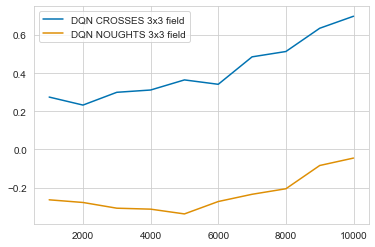

In [26]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'DQN CROSSES 3x3 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'DQN NOUGHTS 3x3 field')
plt.legend()

## Field 4x4x4 

In [27]:
env = TicTacToe(4,4,4)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: 0.071 avg loss: 0.5509193950491026
2000/10000 avg rewards: 0.062 avg loss: 0.6112217182395979
3000/10000 avg rewards: 0.11 avg loss: 0.6156488196626305
4000/10000 avg rewards: 0.142 avg loss: 0.6387671134732663
5000/10000 avg rewards: 0.197 avg loss: 0.6085938592944294
6000/10000 avg rewards: 0.273 avg loss: 0.6174454127606005
7000/10000 avg rewards: 0.409 avg loss: 0.5989341211225837
8000/10000 avg rewards: 0.512 avg loss: 0.6013936912938952
9000/10000 avg rewards: 0.618 avg loss: 0.608510679518804
10000/10000 avg rewards: 0.666 avg loss: 0.5967664017118514



In [28]:
env = TicTacToe(4,4,4)
NN_noughts = DQN_noughts(env.n_cols, 128).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: -0.051 avg loss: 0.22455649224005175
2000/10000 avg rewards: -0.044 avg loss: 0.4516672810371965
3000/10000 avg rewards: -0.017 avg loss: 0.49642980727856045
4000/10000 avg rewards: 0.005 avg loss: 0.4741975678214803
5000/10000 avg rewards: 0.066 avg loss: 0.4820676864809357
6000/10000 avg rewards: 0.003 avg loss: 0.49511022480670364
7000/10000 avg rewards: 0.058 avg loss: 0.47829227474704383
8000/10000 avg rewards: 0.054 avg loss: 0.49115143609838563
9000/10000 avg rewards: 0.142 avg loss: 0.4922408605767414
10000/10000 avg rewards: 0.276 avg loss: 0.4903607673794031



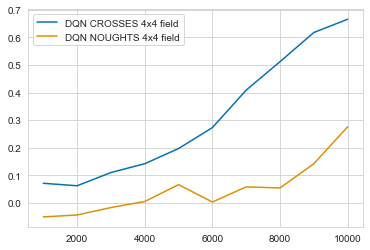

In [29]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'DQN CROSSES 4x4 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'DQN NOUGHTS 4x4 field')
plt.legend()

## Field 5x5x5 

In [30]:
env = TicTacToe(5,5,5)
NN_crosses = DQN(env.n_cols).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: 0.087 avg loss: 0.4798304843360092
2000/10000 avg rewards: 0.072 avg loss: 0.5479410154484212
3000/10000 avg rewards: 0.098 avg loss: 0.5873281538197771
4000/10000 avg rewards: 0.13 avg loss: 0.5769330853512511
5000/10000 avg rewards: 0.154 avg loss: 0.5776506157694384
6000/10000 avg rewards: 0.192 avg loss: 0.605830382751301
7000/10000 avg rewards: 0.217 avg loss: 0.625369393568486
8000/10000 avg rewards: 0.296 avg loss: 0.6529645364722237
9000/10000 avg rewards: 0.354 avg loss: 0.6598694166261703
10000/10000 avg rewards: 0.408 avg loss: 0.6806062501510606



In [31]:
env = TicTacToe(5,5,5)
NN_noughts = DQN_noughts(env.n_cols, 256).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, crosses = -1, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: -0.085 avg loss: 0.251188783487014
2000/10000 avg rewards: -0.061 avg loss: 0.3837405454156251
3000/10000 avg rewards: -0.078 avg loss: 0.3665399968598795
4000/10000 avg rewards: -0.068 avg loss: 0.3907810351625667
5000/10000 avg rewards: -0.023 avg loss: 0.42620686926374035
6000/10000 avg rewards: -0.004 avg loss: 0.38054324225640446
7000/10000 avg rewards: -0.036 avg loss: 0.4211894852969126
8000/10000 avg rewards: -0.025 avg loss: 0.4011572253037302
9000/10000 avg rewards: 0.185 avg loss: 0.43032909955750803
10000/10000 avg rewards: 0.392 avg loss: 0.5146180286158342



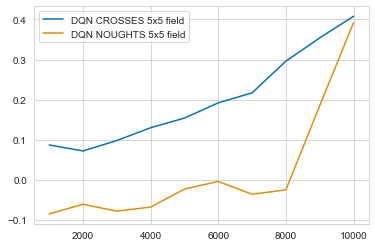

In [32]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'DQN CROSSES 5x5 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'DQN NOUGHTS 5x5 field')
plt.legend()

## Dueling DQN 

In [33]:
class DuelingDQN(nn.Module):
    def __init__(self, field_size, n_chanels):
        super(DuelingDQN, self).__init__()
        self.field_size = field_size
        self.n_chanels = n_chanels
        
        self.conv = nn.Conv2d(1, self.n_chanels, kernel_size = self.field_size)
        self.l = nn.Linear(self.n_chanels, self.field_size * self.field_size)
        self.l2 = nn.Linear(self.n_chanels, 1)
    def forward(self, x):
        x = torch.tanh(self.conv(x))
        b = x.size()[0]
        x = x.view(b, -1)
        
        # Action adv
        z = self.l(x)
        # Value f
        y = self.l2(x)
        ma =  torch.mean(z, dim=1, keepdim=True)
        #https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751
        return z + y - ma

In [40]:
env = TicTacToe(3,3,3)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: 0.297 avg loss: 0.5270036694891751
2000/10000 avg rewards: 0.354 avg loss: 0.643376579143107
3000/10000 avg rewards: 0.27 avg loss: 0.6584400138482451
4000/10000 avg rewards: 0.328 avg loss: 0.6527494532540441
5000/10000 avg rewards: 0.404 avg loss: 0.6578771312758327
6000/10000 avg rewards: 0.459 avg loss: 0.6381367165893316
7000/10000 avg rewards: 0.539 avg loss: 0.6252029235959053
8000/10000 avg rewards: 0.55 avg loss: 0.6315378334671259
9000/10000 avg rewards: 0.513 avg loss: 0.6199462607800961
10000/10000 avg rewards: 0.636 avg loss: 0.6115460866764187



In [41]:
env = TicTacToe(3,3,3)
NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

1000/10000 avg rewards: -0.275 avg loss: 0.448638180822134
2000/10000 avg rewards: -0.282 avg loss: 0.6044504047855734
3000/10000 avg rewards: -0.276 avg loss: 0.630685692332685
4000/10000 avg rewards: -0.233 avg loss: 0.6546558907255531
5000/10000 avg rewards: -0.281 avg loss: 0.6452940035015344
6000/10000 avg rewards: -0.24 avg loss: 0.6477100701034069
7000/10000 avg rewards: -0.163 avg loss: 0.6202323457747698
8000/10000 avg rewards: -0.019 avg loss: 0.6147084494456648
9000/10000 avg rewards: 0.12 avg loss: 0.5874213555976748
10000/10000 avg rewards: 0.029 avg loss: 0.5792830273360013



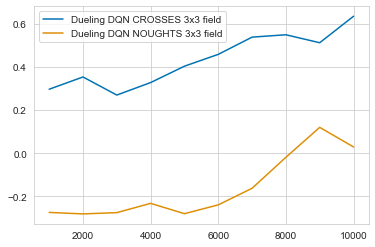

In [42]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'Dueling DQN CROSSES 3x3 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'Dueling DQN NOUGHTS 3x3 field')
plt.legend()

In [43]:
env = TicTacToe(4,4,4)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: 0.07 avg loss: 0.4397423063910101
2000/10000 avg rewards: 0.078 avg loss: 0.5882301671151072
3000/10000 avg rewards: 0.076 avg loss: 0.5955063102925197
4000/10000 avg rewards: 0.111 avg loss: 0.6107837893264368
5000/10000 avg rewards: 0.061 avg loss: 0.6250309352548793
6000/10000 avg rewards: 0.086 avg loss: 0.6239435921050608
7000/10000 avg rewards: 0.112 avg loss: 0.6154590138597414
8000/10000 avg rewards: 0.148 avg loss: 0.6090138963488861
9000/10000 avg rewards: 0.069 avg loss: 0.60484940548148
10000/10000 avg rewards: 0.059 avg loss: 0.5817919497368857



In [44]:
env = TicTacToe(4,4,4)
NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

1000/10000 avg rewards: -0.063 avg loss: 0.42993548350501803
2000/10000 avg rewards: -0.033 avg loss: 0.5756295078508555
3000/10000 avg rewards: -0.063 avg loss: 0.5921140184197575
4000/10000 avg rewards: -0.021 avg loss: 0.6092690694332122
5000/10000 avg rewards: 0.074 avg loss: 0.6228209400679916
6000/10000 avg rewards: 0.027 avg loss: 0.613791748508811
7000/10000 avg rewards: 0.038 avg loss: 0.5979731252547353
8000/10000 avg rewards: -0.007 avg loss: 0.6020574170760811
9000/10000 avg rewards: 0.036 avg loss: 0.5925862390380353
10000/10000 avg rewards: 0.153 avg loss: 0.5303995428290218



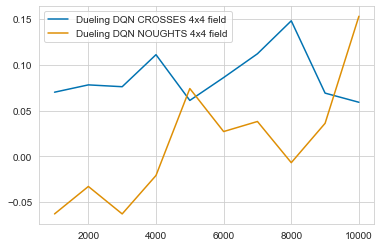

In [45]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'Dueling DQN CROSSES 4x4 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'Dueling DQN NOUGHTS 4x4 field')
plt.legend()

In [47]:
env = TicTacToe(5,5,5)
NN_crosses = DuelingDQN(env.n_cols, 32).to(device)
Q_crosses, crosses_rewards = DQN_train(env, NN_crosses, N_games= 10000, print_every = 1000)

1000/10000 avg rewards: 0.114 avg loss: 0.3916272875427385
2000/10000 avg rewards: 0.103 avg loss: 0.44773474022140725
3000/10000 avg rewards: 0.127 avg loss: 0.4532974959791172
4000/10000 avg rewards: 0.151 avg loss: 0.46110610201023516
5000/10000 avg rewards: 0.125 avg loss: 0.46483821956510657
6000/10000 avg rewards: 0.082 avg loss: 0.5066113131516613
7000/10000 avg rewards: 0.132 avg loss: 0.5223565524343867
8000/10000 avg rewards: 0.12 avg loss: 0.4915479218326509
9000/10000 avg rewards: 0.206 avg loss: 0.47467007152643054
10000/10000 avg rewards: 0.33 avg loss: 0.5809426170475781



In [46]:
env = TicTacToe(5,5,5)
NN_noughts = DuelingDQN(env.n_cols, 32).to(device)
Q_noughts, noughts_rewards = DQN_train(env, NN_noughts, N_games= 10000, crosses = -1, print_every = 1000)

1000/10000 avg rewards: -0.098 avg loss: 0.36620807863748633
2000/10000 avg rewards: -0.088 avg loss: 0.4373246937126387
3000/10000 avg rewards: -0.074 avg loss: 0.43594137496035545
4000/10000 avg rewards: -0.091 avg loss: 0.42074415817670524
5000/10000 avg rewards: -0.075 avg loss: 0.4249956338016782
6000/10000 avg rewards: -0.097 avg loss: 0.4327965251118876
7000/10000 avg rewards: -0.043 avg loss: 0.43047508445591665
8000/10000 avg rewards: -0.113 avg loss: 0.45316736374329775
9000/10000 avg rewards: -0.069 avg loss: 0.4746567902409006
10000/10000 avg rewards: -0.104 avg loss: 0.46217019686684946



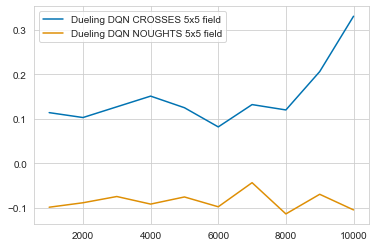

In [48]:
plt.plot(np.array(list(range(1,11)))*1000, crosses_rewards, label = 'Dueling DQN CROSSES 5x5 field')
plt.plot(np.array(list(range(1,11)))*1000, noughts_rewards, label = 'Dueling DQN NOUGHTS 5x5 field')
plt.legend()

# Task 3

## Rollouts 

here we doing rollouts till the end of the game, for every step in the game 

In [49]:
def rollout(env, strategy, nrolls, crosses, *args, **kwargs):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    rewards = {el: [] for el in possible_actions}
    for i in range(nrolls):
        for act in possible_actions:
            cur_env = deepcopy(env)
            _, reward, done, _ = cur_env.step(cur_env.action_from_int(act))
            if done:
                rewards[act].append(reward * crosses)
                continue
                
            while True:
                #opponents turn
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                opponents_action = np.random.choice(p_actions)
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
                if done:
                    rewards[act].append(reward * crosses)
                    break
                
                #our turn
                p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
                our_action = strategy(cur_env, *args, **kwargs)
                
                _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
                if done:
                    rewards[act].append(reward * crosses)
                    break
                    
    actions = {el: np.mean(rewards[el]) for el in possible_actions}
    maxi = -10
    max_act = 0
    for act in actions.keys():
        if actions[act] > maxi:
            max_act = act
            maxi = actions[act]
    return max_act, actions

In [50]:
def rollout_game(env, strategy, nrolls = 100, crosses = 1, *args, **kwargs):
    if crosses != env.curTurn:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
    
    while True:
        #our turn
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        our_action, _ = rollout(env, strategy, nrolls, crosses, *args, **kwargs)
                
        _, reward, done, _ = env.step(env.action_from_int(our_action))
        
        if done:
            return reward * crosses
        
        #opponents turn
        p_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        
        _, reward, done, _ = env.step(env.action_from_int(opponents_action))
        
        if done:
            return reward * crosses

In [51]:
def random_str(env):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    return possible_actions[np.random.choice(len(possible_actions))]

In [52]:
env = TicTacToe(3,3,3)
env.reset()

In [53]:
rewards = []
for i in tqdm_notebook(range(100)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 100))
    
print(np.mean(rewards))


0.99


In [54]:
rewards = []
for i in tqdm_notebook(range(100)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 100, crosses = -1))
    
print(np.mean(rewards))


0.89


In [55]:
env = TicTacToe(4,4,4)
env.reset()

In [56]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20))
    
print(np.mean(rewards))


1.0


In [57]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20, crosses = -1))
    
print(np.mean(rewards))


0.7


In [58]:
env = TicTacToe(5,5,5)
env.reset()

In [59]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20))
    
print(np.mean(rewards))


1.0


In [60]:
rewards = []
for i in tqdm_notebook(range(20)):
    env.reset()
    rewards.append(rollout_game(env, random_str, nrolls = 20, crosses = -1))
    
print(np.mean(rewards))


0.8


## MCTS

In [61]:
def replace(s, position, character):
    return s[:position] + character + s[position+1:]

In [62]:
C = 0.8

class Node():
    def __init__(self):
        self.parent = None
        self.children = {}
        self.visits = 0
        self.value = 0
        self.state = None
        self.index = 0
        self.storage = None
    
    def ucb(self):
        if self.visits == 0:
            return float('inf')
        return self.value / self.visits + C * math.sqrt(math.log(self.storage[self.parent].visits) / self.visits)
    
    def create_children(self):
        if self.is_leaf():
            np_state = np.array(list(map(int, self.state)))
            available_actions = np.where(np_state == 1)[0]
            if (len(self.state) - len(available_actions)) % 2 == 0:
                curTurn = 1
            else:
                curTurn = -1
            for action in available_actions:
                child = Node()
                child.parent = self.index
                child.state = replace(self.state, action, str(curTurn + 1))
                child.index = len(self.storage)
                child.storage = self.storage
                self.children[action] = child.index
                self.storage.append(child)
    
    def is_leaf(self):
        return len(self.children) == 0
    
    def select_child(self, how="best"):
        eps = 0.7
        if how == "best":
            fun = max
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "worse":
            fun = min
            characteristic = lambda x: self.storage[x[1]].ucb()
        elif how == "random":
            return random.choice(list(self.children.items()))
        else:
            fun = None
            characteristic = None
        if not self.is_leaf():
            return max(self.children.items(), key=characteristic)

In [63]:
 def rollout(env, strategy, nrolls, crosses, *args, **kwargs):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    cur_env= deepcopy(env)
    done = env.gameOver
    if done:
        return 0 
    
    while True:
        #our turn
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        our_action = strategy(cur_env, *args, **kwargs)
                
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(our_action))
        if done:
            return reward * crosses
        
        #opponents turn
        p_actions = [cur_env.int_from_action(cur_env.getEmptySpaces()[i]) for i in range(len(cur_env.getEmptySpaces()))]
        opponents_action = np.random.choice(p_actions)
        _, reward, done, _ = cur_env.step(cur_env.action_from_int(opponents_action))
        if done:
            return reward * crosses
                

In [64]:
class Mcts():
    def __init__(self, env, crosses = 1):
        self.env = env
        self.env.reset()
        self.crosses = crosses
        self.nodes = []

        root = Node()
        root.state = self.env.getState()[0]
        root.index = 0
        root.storage = self.nodes
        self.nodes.append(root)
        
        self.current_node = 0
        
    def next_step(self):
        action, self.current_node = self.nodes[self.current_node].select_child()
        self.env.step(self.env.action_from_int(action))
    
    def selection(self):
        while not self.nodes[self.current_node].is_leaf():
            self.next_step()
    
    def expansion(self):
        if not self.env.gameOver:
            if self.nodes[self.current_node].visits > 0:
                self.nodes[self.current_node].create_children()
                self.next_step()
    
    def simulation(self):
        return rollout(self.env, random_str, 1, self.crosses)
    
    def backpropagation(self, r):
        while self.nodes[self.current_node].parent is not None:
            self.nodes[self.current_node].visits += 1
            self.nodes[self.current_node].value += r
            self.current_node = self.nodes[self.current_node].parent
        self.nodes[self.current_node].visits += 1
        self.nodes[self.current_node].value += r
    
    def learn(self, n_episodes=10000):
        for _ in tqdm_notebook(range(n_episodes)):
            assert self.current_node == 0
            self.env.reset()
            self.selection()
            self.expansion()
            r = self.simulation()
            self.backpropagation(r)

In [65]:
def run(model, n_episodes = 12, crosses = 1):
    cum_rewards = 0
    count_games = 0
    for _ in range(n_episodes):
        model.env.reset()
        model.current_node = 0
        if crosses == 1:
            hows = [None, "best", "random"]
        elif crosses == -1:
            hows = [None, "random", "worse"]
        else:
            hows = None
        while not model.nodes[model.current_node].is_leaf():
            action, model.current_node = model.nodes[model.current_node].select_child(hows[model.env.curTurn])
            _, reward, done, _ = model.env.step(model.env.action_from_int(action))
        if done:
            cum_rewards += reward
            count_games += 1
    mean_reward = cum_rewards / count_games
    print(f"Mean reward vs random policy equal {mean_reward} after {count_games} games.")
    return mean_reward

the end of the episode is always in the leaf node but it is not always terminal -> the game is not finished. I don't count these games and only count when terminal node == leaf node

In [66]:
env = TicTacToe(3,3,3)

mcts = Mcts(env, 1000000)
mcts.learn()
run(mcts, 10000)


Mean reward vs random policy equal 0.7706692913385826 after 2032 games.


0.7706692913385826

In [69]:
env = TicTacToe(4,4,4)

mcts = Mcts(env, 10000000)
mcts.learn()
run(mcts, 100000)


Mean reward vs random policy equal 1.0 after 13 games.


1.0